## 4 Parameter Selection

This notebook can be used to learn all options and various parameters settings of background subtraction algorithms used for movement detection, and see how they influence the results. You can use this notebook to optimize the settings for background subtraction applications in your own videos.

**NOTE:** the examples in this notebook are specifically useful for finding optimal settings for **location detection**. We do this by detecting pixels that change relative to the background of the video frames, and taking their spatial mean. If you use background segmentation for a different application, you can still follow the overall procedure the explore parameter space, but you probably want to use different value ranges.

In [56]:
import birdwatcher as bw
import birdwatcher.movementdetection as md
from birdwatcher.plotting import imshow_frame # birdwatcher has vizualization tools

import matplotlib.pyplot as plt
%matplotlib inline

### Select video fragment

Choose a short representative video fragment where the object of interest is moving quite a lot. See notebook 1 for more information of how to select a video fragment or a region of interest (roi and nroi).

In [57]:
vfs = bw.VideoFileStream(r'..\videos\zf20s_low.mp4')

# select video fragment
startat = '00:00:00'   # in HOURS:MM:SS
nframes = 375   # is 15 seconds

# specify h1, h2, w1, w2, or choose None to use the whole frame
roi = (10, 570, 10, 1250)   # region of interest
nroi = (600, 720, 0, 1280)   # nót region of interest

Check roi and nroi in frame:

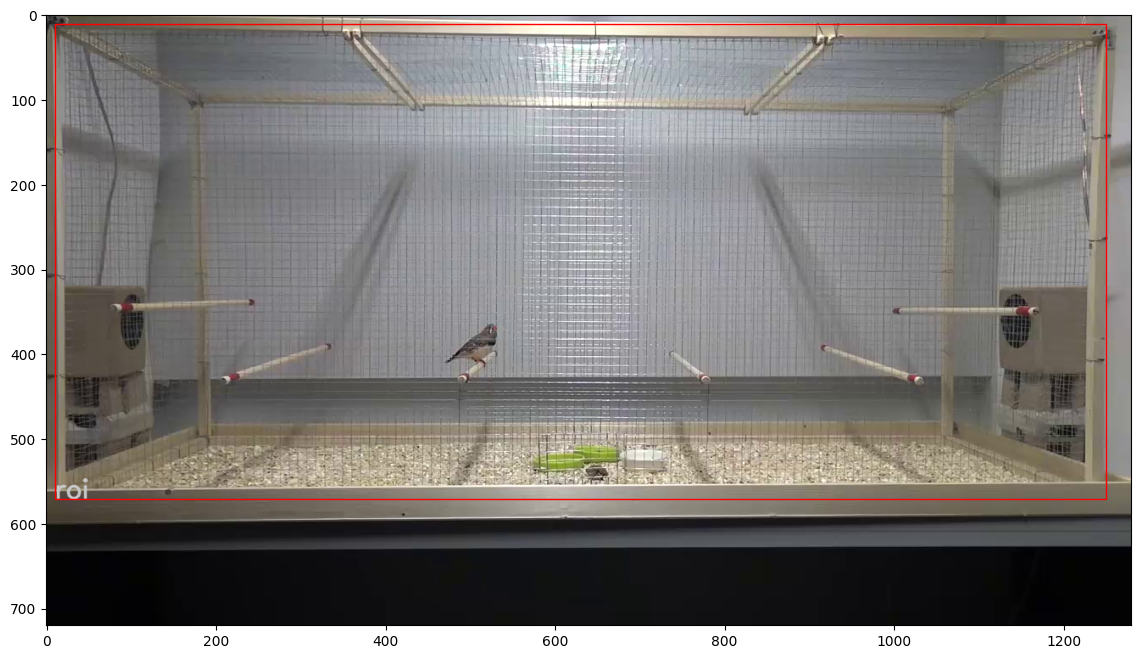

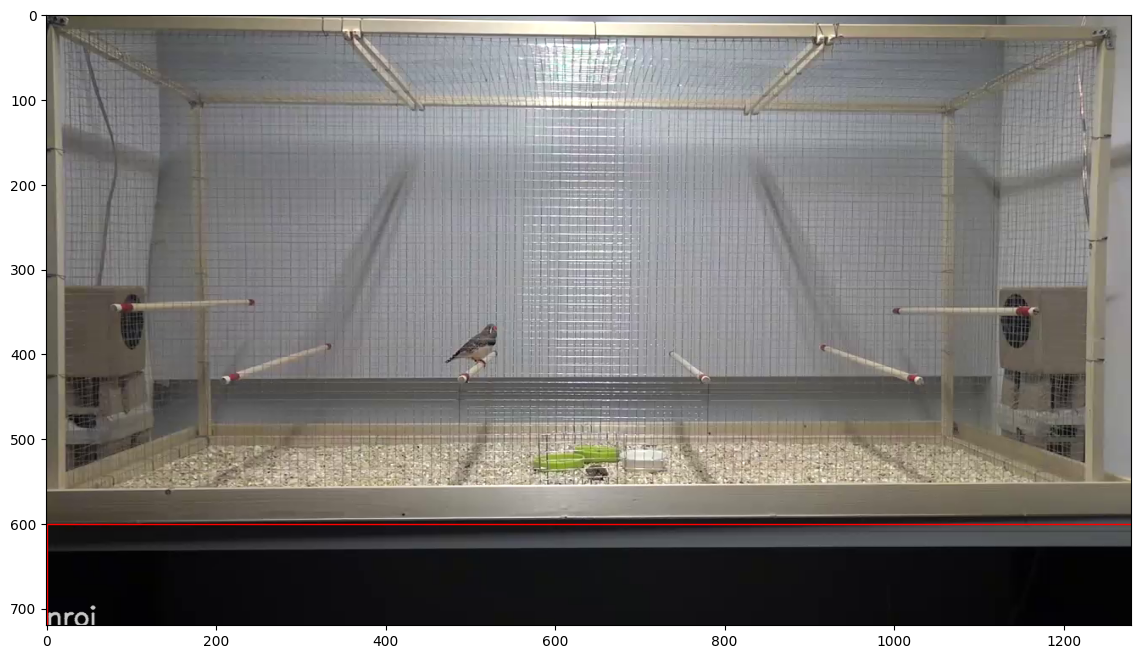

In [58]:
frame = vfs.iter_frames(startat=startat, nframes=nframes).peek_frame()

if roi is not None:
    frame = vfs.iter_frames(startat=startat, nframes=1).draw_text(['roi'], org=(roi[2],roi[1]))
    imshow_frame(frame.peek_frame(), draw_rectangle=roi)

if nroi is not None:
    frame = vfs.iter_frames(startat=startat, nframes=1).draw_text(['nroi'], org=(nroi[2],nroi[1]))
    imshow_frame(frame.peek_frame(), draw_rectangle=nroi)

Look at the chosen video fragment. If video windowdoes not appears to foreground, it is playing in the background. Use 'q' to quit before end.

In [59]:
vfs.iter_frames(startat=startat, nframes=nframes).show(framerate=vfs.avgframerate)

### Choose suitable parameters

Our goal is to find optimal parameters for the detection of the location of the bird in the cage during the video. We explore parameter setting by varying values and options to see what works best. In this case we are interested in detecting the location of the bird that moves around. The method below helps to explore parameter space.

This exploration is a process that you only need to go through once if the nature of the videos you want to analyze don't change much, and only when default settings in Birdwatcher do not work satisfactorily for you.

In this example, we will use background subtractor MOG2. For more information of the background subtraction algorithms make sure to look at notebook 2.

We first create a python dictionary where we specify the background segmenter parameter values for MOG2 and processing parameter values that we want to check out. Every parameter name has a list of values that will be tested. To explore parameters of a different algorithm just modify the dictionary below with the appropriate parameters.

In the dictionary below, decide which settings you would like by adding one or more values in the list after each parameter.

Note that all combinations of parameter values will be tested, so the number of tests can explode quickly if you add many. It is probably best not to expore settings of many parameters at the same time.

In [107]:
settings = {'bgs_params':  {'History': [3, 6, 12],                    # we test three values for History parameter
                            'ComplexityReductionThreshold': [0.05],   # just one for ComplexityReductionThreshold
                            'BackgroundRatio': [0.1],                 # ... etc
                            'NMixtures': [7],
                            'VarInit': [15],
                            'VarMin': [4, 10],
                            'VarMax': [75],
                            'VarThreshold': [30, 70],
                            'VarThresholdGen': [9],
                            'DetectShadows': [False],
                            'ShadowThreshold': [0.5],
                            'ShadowValue': [0]},

            'processing':  {'color': [True, False],                  # booleans only
                            'resizebyfactor': [1],            # use '1' for no change in size #(2/3)
                            'blur': [0, 10],                         # use '0' for no blur
                            'morphologyex': [True]}}          # booleans only # False

all_combinations = list(md.product_dict(**settings['bgs_params'], **settings['processing']))
print(f'There are {len(all_combinations)} different combinations of settings to perform movement detection.')

There are 48 different combinations of settings to perform movement detection.


The higher the number of combinations, the longer the next step will take. Another option is to start by tweaking some parameters, and fine-tune in next rounds by running this notebook again with different settings.

### Run movemement detection per combination of settings

Movement detection is performed with each combination of settings, and the mean coordinate per frame is saved in a Pandas dataframe.

**WARNING:** This step might take a while, depending on the number of settings combinations! To shorten runtime, reduce the number of combinations and/or choose a shorter videofragment.

In [108]:
%%time
params = md.apply_all_parameters(vfs, settings, bgs_type=bw.BackgroundSubtractorMOG2, 
                                 startat=startat, nframes=nframes, roi=roi, nroi=nroi,
                                 reportprogress=25)

25 combinations of settings applied in 0:05:47 hours:min:sec
CPU times: total: 11min 13s
Wall time: 11min


To get the optimal parameter settings, you'll probably do several rounds with a different combination of settings. Then, a new project folder is created with a number added as suffix to the foldername to display the round.

The output of applying all parameters is a `ParameterSelection` object, which contains information of the videofragment and the results of all setting combinations.

In [109]:
params.get_info()

{'vfs': '..\\videos\\zf20s_low.mp4',
 'bgs_type': "<class 'birdwatcher.backgroundsubtraction.BackgroundSubtractorMOG2'>",
 'startat': '00:00:00',
 'nframes': 375,
 'roi': (10, 570, 10, 1250),
 'nroi': (600, 720, 0, 1280)}

In [110]:
params.df

,framenumber,History,ComplexityReductionThreshold,BackgroundRatio,NMixtures,VarInit,VarMin,VarMax,VarThreshold,VarThresholdGen,DetectShadows,ShadowThreshold,ShadowValue,color,resizebyfactor,blur,morphologyex,coords,pixel
0,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,1,0,True,x,630.5
1,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,1,0,True,y,290.5
2,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,1,10,True,x,630.5
3,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,1,10,True,y,290.5
4,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,True,1,0,True,x,630.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,374,12,0.05,0.1,7,15,10,75,70,9,False,0.5,0,False,1,10,True,y,290.5
35996,374,12,0.05,0.1,7,15,10,75,70,9,False,0.5,0,True,1,0,True,x,630.5
35997,374,12,0.05,0.1,7,15,10,75,70,9,False,0.5,0,True,1,0,True,y,290.5
35998,374,12,0.05,0.1,7,15,10,75,70,9,False,0.5,0,True,1,10,True,x,630.5


Here, you see a pandas dataframe with in the columns all parameters that are used to run location detection. The rows show the specific value of each parameter and the resulted mean x,y coordinates per frame (NaN means there were no nonzero pixels found for that frame). 

You can save the results to a path. Results are saved in a subfolder with the name of the VideoFileStream file. You can read this later with the `load_parameterselection` function, and continue with the analyses (see below). Also, a readme.txt file with the parameter settings is saved to quickly look up which settings were used.

In [111]:
params.save_parameters(f'output/')

In [112]:
params.path

'output\\params_zf20s_low_3'

### Load ParameterSelection

You can run and save `apply_all_parameters`, and later look at the results by loading a `ParameterSelection` object like this:

In [113]:
params = md.load_parameterselection(f'output\params_zf20s_low_2')

Make sure the location of the original video where the `ParameterSelection` object is based on, has not changed. Then, it is also possible to load the associated videofilestream directly:

In [114]:
params.vfs

Or watch the shorter videofragment of which the `ParameterSelection` object is based on:

In [115]:
frames_fragment = params.get_videofragment()
frames_fragment.show()

To access the data as Pandas dataframe, run:

In [116]:
params.df

,framenumber,History,ComplexityReductionThreshold,BackgroundRatio,NMixtures,VarInit,VarMin,VarMax,VarThreshold,VarThresholdGen,DetectShadows,ShadowThreshold,ShadowValue,color,resizebyfactor,blur,morphologyex,coords,pixel
0,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,0.666667,0,False,x,527.516751
1,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,0.666667,0,False,y,242.074199
2,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,0.666667,0,True,x,528.516751
3,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,0.666667,0,True,y,243.074199
4,0,3,0.05,0.1,7,15,4,75,30,9,False,0.5,0,False,0.666667,10,False,x,527.516751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,374,12,0.05,0.1,7,15,10,75,70,9,False,0.5,0,True,1.000000,0,True,y,290.500000
143996,374,12,0.05,0.1,7,15,10,75,70,9,False,0.5,0,True,1.000000,10,False,x,629.500000
143997,374,12,0.05,0.1,7,15,10,75,70,9,False,0.5,0,True,1.000000,10,False,y,289.500000
143998,374,12,0.05,0.1,7,15,10,75,70,9,False,0.5,0,True,1.000000,10,True,x,630.500000


### Correction resizebyfactor

If you've used setting 'resizebyfactor' this has changed the width and height of the frames. Below, we correct for this change in pixel resolution, so that it's easier to see and compare the effects of different settings on the movementdetection results below.

In [121]:
params.df['pixel'] = params.df['pixel'] / params.df['resizebyfactor']
params.df.loc[:, ('resizebyfactor', 'coords', 'pixel')]

,resizebyfactor,coords,pixel
0,0.666667,x,791.275126
1,0.666667,y,363.111299
2,0.666667,x,792.775126
3,0.666667,y,364.611299
4,0.666667,x,791.275126
...,...,...,...
143995,1.000000,y,290.500000
143996,1.000000,x,629.500000
143997,1.000000,y,289.500000
143998,1.000000,x,630.500000


### Visualize results

Before visualizing the results, look again at all settings.

In [122]:
# the following settings have been used for backgroundsubstraction in this dataframe
params.get_parameters('all')

{'VarInit': [15],
 'morphologyex': [False, True],
 'ComplexityReductionThreshold': [0.05],
 'NMixtures': [7],
 'ShadowValue': [0],
 'VarMax': [75],
 'History': [3, 6, 12],
 'BackgroundRatio': [0.1],
 'resizebyfactor': [0.6666666666666666, 1.0],
 'VarThreshold': [30, 70],
 'ShadowThreshold': [0.5],
 'VarThresholdGen': [9],
 'DetectShadows': [False],
 'color': [False, True],
 'VarMin': [4, 10],
 'blur': [0, 10]}

Here, you see for which settings multiple values have been used to run movement detection. So, these are also the settings that are interesting to compare in plots or superimpose on the video fragment.

In [123]:
# the following settings have been tested with multiple values
params.get_parameters('multi_only')

{'morphologyex': [False, True],
 'History': [3, 6, 12],
 'resizebyfactor': [0.6666666666666666, 1.0],
 'VarThreshold': [30, 70],
 'color': [False, True],
 'VarMin': [4, 10],
 'blur': [0, 10]}

#### Plots

First, choose for each parameter with multiple values which value is the default. TIP: you can copy the output dictionary above and choose one of the values in each list. Use the value of which you think will provide the best location detection. If you have no idea, don't worry, just choose one.

In [124]:
default_values = {'resizebyfactor': 1.0,
                  'color': True,
                  'VarThreshold': 30,
                  'blur': 0,
                  'morphologyex': False,
                  'History': 4,
                  'VarMin': 4}

You can plot the results of two parameters in one figure. The different values of one parameter is outlined in the rows and the other parameter in the columns of the subplots.

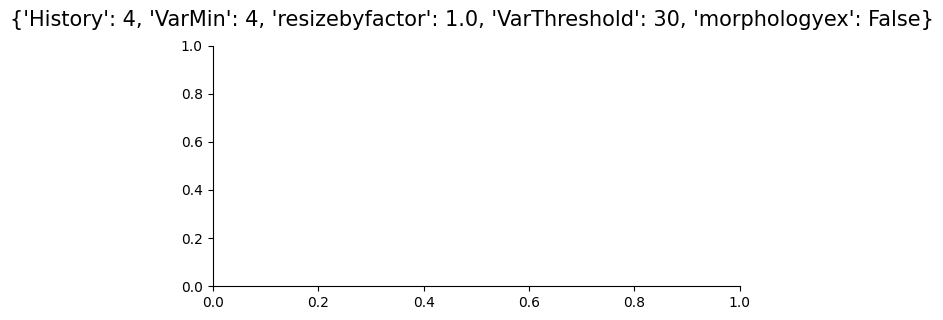

In [125]:
rows = 'blur'
cols = 'color'

g = params.plot_parameters(rows, cols, default_values)

Here you see the results of using different settings for 'blur' and 'color'. The settings for the other parameters are the ones you've specified as default.

To save the plots of all combinations of parameters, use the function below.

In [126]:
params.batch_plot_parameters(default_values)

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\anaconda3\envs\mybirdwatcher\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

The figures are saved in output\params_zf20s_low_2\figures_3


The figures are saved in the same directory as where the associated ParameterSelection dataframe is saved. You can go to the folder where the figures are saved and walk through the figures. That way you get a sense of the influence of various parameter-value combinations on location detection.

For certain parameters, you might see large noise differences for the different values. For these parameters, choose the best value (the one with the least noise), and use these values as default. Run the above cells again with the new default values. The figures will be saved in a new folder (figures_2). Look again at the figures. Do this several rounds, untill you get an idea of which parameter-value combinations provide the best (least noisy) location detection.

#### Superimpose on video

In the plots you get an idea of which paramater-value combinations result in the least noisy graphs. However, it is not possible to see whether the pixel coordinates also accurately match the location of the bird. For this, it is usefull to plot the mean coordinates directly on top of the video.

In [77]:
params.get_parameters('multi_only')

{'morphologyex': [False, True],
 'History': [3, 6, 12],
 'resizebyfactor': [0.6666666666666666, 1.0],
 'VarThreshold': [30, 70],
 'color': [False, True],
 'VarMin': [4, 10],
 'blur': [0, 10]}

Again, look at the parameters with multiple values. Choose from these parameters which values you would like to see plotted as circle on the videofragment.

In [78]:
# choose which settings to superimpose on the videofragment
settings = {'resizebyfactor': [1.0],
            'color': [False],
            'VarThreshold': [30, 70],
            'blur': [0, 10],
            'morphologyex': [True],
            'History': [4],
            'VarMin': [10]}

all_combinations = list(md.product_dict(**settings))
print(f'There are {len(all_combinations)} combinations of settings to superimpose on a video.')

There are 4 combinations of settings to superimpose on a video.


Too many circles plotted on the video are hard to follow. As default, a maximum of 6 circles can be superimposed on one videofragment, but often you'll probably want to plot less circles.

In [79]:
# draw circles on videofragment
frames, colorspecs = params.draw_multiple_circles(settings)

StopIteration: 

In [ ]:
# show the settings for each color of the circles
colorspecs

In [ ]:
# look at the video using show()
frames.show(framerate=20)

TIP: a lower framerate makes it easier to follow the circles.

In [ ]:
# or, save as video with circles superimposed
vfs_circles = frames.tovideo(f'{params.path}/multicircles.mp4', framerate=params.vfs.avgframerate)

In [ ]:
# you can also save the color specification
colorspecs.to_csv(f'{params.path}/multicircles_colorspecs.csv')

Now, you have an idea which parameters have a large influence on movement detection. You might want to run the notebook again and test some other values or the parameters to fine-tune your results even more. Just repeat all the steps above.

Also, repeat these steps with a second short representative videofragment to make sure the same parameter-value combinations provide the best results. After that, you could use these settings to run movement detection on all your videos. For this, have a look at the next notebook!